In [1]:
import pandas as pd
import evaluate
from datasets import load_dataset, Audio
from transformers import pipeline, AutoProcessor, AutoModelForPreTraining, Wav2Vec2Processor, Wav2Vec2ForCTC, HubertForCTC, AutoModelForSpeechSeq2Seq
import torch
from itertools import islice
import nemo.collections.asr as nemo_asr
import matplotlib.pyplot as plt     
import io, base64, soundfile as sf
from nemo.collections.speechlm2.models import SALM
from elevenlabs.client import ElevenLabs
import tempfile
import soundfile as sf

/root/workspace/experiment/experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# 1. Define models and datasets
models = [
    # "facebook/wav2vec2-base-960h",
    # "facebook/hubert-large-ls960-ft",
    # "openai/whisper-large-v3",
    # "ibm-granite/granite-speech-3.3-8b",
    # "nvidia/parakeet-tdt-0.6b-v2",
    # "mistralai/Voxtral-Mini-3B-2507",
    "nvidia/canary-qwen-2.5b"
    # "elevenlabs/scribe_v1",
]

datasets_info = [
    ("mozilla-foundation/common_voice_16_1", {"split": "test", "field": "sentence"}),
    ("openslr/librispeech_asr",      {"split": "test.clean", "field": "text"}),
    ("openslr/librispeech_asr",      {"split": "test.other", "field": "text"}),
    # ("espnet/yodas2",                {"field": "text"}),
    ("edinburghcstr/ami",            {"split": "test", "config": "ihm", "field": "text"}),
    ("edinburghcstr/ami",            {"split": "test", "config": "sdm", "field": "text"}),
    ("distil-whisper/earnings22",    {"split": "test",       "field": "transcription"}),
    ("facebook/voxpopuli",       {"split": "test",       "field": "raw_text"}),
    ("google/fleurs",            {"split": "test",       "field": "transcription"}),
    ("MLCommons/peoples_speech", {"split": "test[:100]", "field": "text"}),
]

In [11]:
# 2. Load metrics
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

In [12]:
# 3. Loop over models & datasets
results = []
device = "cuda"

for model_name in models:
    print(f"\nLoading pipeline for {model_name}…")
    if "whisper" in model_name:
        model_id = "openai/whisper-large-v3"

        model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id, torch_dtype=torch.float16, low_cpu_mem_usage=True, use_safetensors=True
        )
        model.to(device)

        processor = AutoProcessor.from_pretrained(model_id)

        asr = pipeline(
            "automatic-speech-recognition",
            model=model,
            tokenizer=processor.tokenizer,
            feature_extractor=processor.feature_extractor,
            torch_dtype=torch.float16,
            device=device,
            generate_kwargs={"language": "english"}
        )
    elif "960h" in model_name:
        processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", sampling_rate=16_000 )
        asr = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
    elif "hubert" in model_name:
        processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft", sampling_rate=16_000 )
        asr = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(device)
    elif "parakeet" in model_name:
        asr = nemo_asr.models.ASRModel.from_pretrained("nvidia/parakeet-tdt-0.6b-v2").to(device)
    elif "ibm" in model_name:
        processor = AutoProcessor.from_pretrained("ibm-granite/granite-speech-3.3-8b")
        tokenizer = processor.tokenizer
        asr = AutoModelForSpeechSeq2Seq.from_pretrained("ibm-granite/granite-speech-3.3-8b").to(device)
        chat = [
            {
                "role": "system",
                "content": "Knowledge Cutoff Date: April 2024.\nToday's Date: April 9, 2025.\nYou are Granite, developed by IBM. You are a helpful AI assistant",
            },
            {
                "role": "user",
                "content": "<|audio|>can you transcribe the speech into a written format?",
            }
        ]
        text = tokenizer.apply_chat_template(
            chat, tokenize=False, add_generation_prompt=True
        )
    elif "mistralai" in model_name:
        from mistral_common.protocol.transcription.request import TranscriptionRequest
        from mistral_common.protocol.instruct.messages import RawAudio

        from openai import OpenAI

        # Modify OpenAI's API key and API base to use vLLM's API server.
        openai_api_key = "EMPTY"
        openai_api_base = "http://localhost:8000/v1"

        client = OpenAI(
            api_key=openai_api_key,
            base_url=openai_api_base,
        )

        remote_models = client.models.list()
        model = remote_models.data[0].id
    elif "elevenlabs" in model_name:


        client = ElevenLabs(api_key="sk_074ef5ad62c4e611a999f09a00644a29bfed337e4a5c9dc5")
    elif "canary" in model_name:
        model = SALM.from_pretrained('nvidia/canary-qwen-2.5b').to(device)



    for ds_name, cfg in datasets_info:
        print(f"→ Dataset: {ds_name} ")
        if "mozilla" in ds_name:
            ds = load_dataset(ds_name, "en", split=cfg["split"], streaming=True, trust_remote_code=True)
        elif "espnet" in ds_name:
            ds = load_dataset(ds_name, 'en000', streaming=True, trust_remote_code=True)
        elif "edinburghcstr/ami" in ds_name:
            config = cfg.get("config", "ihm")  # Default to "ihm" if no config specified
            ds = load_dataset(ds_name, config, split=cfg["split"], streaming=True, trust_remote_code=True)
        elif "distil-whisper/earnings22" in ds_name:
            ds = load_dataset(ds_name, "chunked", split=cfg["split"], streaming=True, trust_remote_code=True)
        elif "voxpopuli" in ds_name:
            ds = load_dataset(ds_name, "en_accented", split=cfg["split"])
        elif "google/fleurs" in ds_name:
            ds = load_dataset(ds_name, "en_us", split=cfg["split"], streaming = True, trust_remote_code=True)
        elif "MLCommons/peoples_speech" in ds_name:
            ds = load_dataset(ds_name, "test", split=cfg["split"], trust_remote_code=True)
        else:
            ds = load_dataset(ds_name, split=cfg["split"], streaming = True, trust_remote_code=True)
        ds = ds.cast_column("audio", Audio(sampling_rate=16_000))   
        
        # Filter VoxPopuli entries longer than 30 seconds
        if "voxpopuli" in ds_name or "MLCommons/peoples_speech" in ds_name:
            def filter_duration(example):
                audio_length = len(example["audio"]["array"]) / example["audio"]["sampling_rate"]
                return audio_length <= 30.0
            ds = ds.filter(filter_duration)
            print(f"    Filtered VoxPopuli to keep only entries ≤ 30 seconds")
        
        # Optionally limit number of examples (e.g., first 100) for speed:
        # if "voxpopuli" not in ds_name:
        #     ds = list(islice(ds, 100)) # Remove or adjust as needed
        # else:
        #     # For VoxPopuli, take first 100 after filtering
        if "MLCommons/peoples_speech" not in ds_name:
            ds = list(islice(ds, 100))
        
        refs, hypos = [], []
        for ex in ds:
            audio = ex["audio"]
            # pipeline can take path or array+sampling_rate
            if "parakeet" in model_name:
                pred = asr.transcribe(audio["array"])[0].text
            elif "960h" in model_name or "hubert" in model_name:
                input_vals = processor(audio["array"], return_tensors="pt", padding="longest")
                input_values = input_vals.input_values.to(device)
                attention_mask = input_vals.attention_mask.to(device)

                logits = asr(input_values, attention_mask=attention_mask).logits
                predicted_ids = torch.argmax(logits, dim=-1)
                pred = processor.batch_decode(predicted_ids)[0]
            elif "ibm" in model_name:
                model_inputs = processor(
                    text,
                    audio["array"],
                    device=device, # Computation device; returned tensors are put on CPU
                    return_tensors="pt",
                ).to(device)
                model_outputs = asr.generate(
                    **model_inputs,
                    max_new_tokens=200,
                    num_beams=4,
                    do_sample=False,
                    min_length=1,
                    top_p=1.0,
                    repetition_penalty=1.0,
                    length_penalty=1.0,
                    temperature=1.0,
                    bos_token_id=tokenizer.bos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                )
                num_input_tokens = model_inputs["input_ids"].shape[-1]
                new_tokens = torch.unsqueeze(model_outputs[0, num_input_tokens:], dim=0)

                output_text = tokenizer.batch_decode(
                    new_tokens, add_special_tokens=False, skip_special_tokens=True
                )
                pred = output_text[0]
                # print(f"Pred: {pred}")
            elif "mistralai" in model_name:
                # 1) Write the array into a WAV buffer
                buf = io.BytesIO()
                sf.write(buf, audio["array"], samplerate=audio["sampling_rate"], format="WAV")
                buf.seek(0)

                # 2) Base‑64–encode the bytes and build a RawAudio
                wav_bytes = buf.read()
                raw = RawAudio(
                    data=base64.b64encode(wav_bytes).decode("utf-8"),
                    format="wav"
                )

                # 3) Build your TranscriptionRequest
                req = TranscriptionRequest(
                    model=model,
                    audio=raw,
                    language="en",
                    temperature=0.0
                ).to_openai(exclude=("top_p", "seed"))

                response = client.audio.transcriptions.create(**req)
                pred = response.text
            elif "elevenlabs" in model_name:
                audio_array = audio["array"]
                sample_rate = audio["sampling_rate"]  # make sure this is provided

                buffer = io.BytesIO()
                sf.write(buffer, audio_array, sample_rate, format="WAV")
                buffer.seek(0)  # move to start of buffer for reading
                audio_data = audio["array"]
                response = client.speech_to_text.convert(
                    file=buffer,
                    model_id="scribe_v1",
                    language_code="en",
                    tag_audio_events=False,
                        diarize=False,
                    )
                pred = response.text.strip()
            elif "canary" in model_name:
                with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmpfile:
                    sf.write(tmpfile.name, audio["array"], audio["sampling_rate"])
                    tmp_path = tmpfile.name
                answer_ids = model.generate(
                    prompts=[
                        [{"role": "user", "content": f"Transcribe the following: {model.audio_locator_tag}","audio": tmp_path}]
                    ],
                    max_new_tokens=128,
                )
                pred = model.tokenizer.ids_to_text(answer_ids[0].cpu())
            else:
                pred = asr(audio["array"], generate_kwargs={"language": "english"})["text"]
            hypos.append(pred.strip().lower())
            refs.append(ex[cfg["field"]].strip().lower())
        
        wer = wer_metric.compute(references=refs, predictions=hypos)
        cer = cer_metric.compute(references=refs, predictions=hypos)
        print(f"    WER: {wer:.3f},  CER: {cer:.3f}")
        
        dataset_name = ds_name
        if "openslr/librispeech_asr" in ds_name:
            dataset_name = f"{ds_name}-{cfg['split']}"
        if "edinburghcstr/ami" in ds_name:
            dataset_name = f"{ds_name}-{cfg.get('config', 'ihm')}"
        
        results.append({
            "model": model_name,
            "dataset": dataset_name,
            "split": cfg["split"],
            "WER": wer,
            "CER": cer
        })


Loading pipeline for nvidia/canary-qwen-2.5b…


[NeMo I 2025-07-25 09:57:40 nemo_logging:393] 1 special tokens added, resize your model accordingly.
[NeMo I 2025-07-25 09:58:07 nemo_logging:393] LoRA adapter installed: LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='Qwen/Qwen3-1.7B', revision=None, inference_mode=False, r=128, target_modules=['q_proj', 'v_proj'], exclude_modules=None, lora_alpha=256, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)
[NeMo I 2025-07-25 09:58:07 nemo_logging:393] PADDING: 0
→ Dataset: mozilla-foundat

Reading metadata...: 16390it [00:00, 27546.20it/s]
`generation_config` default values have been modified to match model-specific defaults: {'bos_token_id': 151643}. If this is not desired, please set these values explicitly.


    WER: 0.217,  CER: 0.106
→ Dataset: openslr/librispeech_asr 
    WER: 0.112,  CER: 0.025
→ Dataset: openslr/librispeech_asr 
    WER: 0.145,  CER: 0.048
→ Dataset: edinburghcstr/ami 
    WER: 0.287,  CER: 0.211
→ Dataset: edinburghcstr/ami 
    WER: 0.581,  CER: 0.438
→ Dataset: distil-whisper/earnings22 
    WER: 0.315,  CER: 0.140
→ Dataset: facebook/voxpopuli 
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    WER: 0.182,  CER: 0.105
→ Dataset: google/fleurs 
    WER: 0.138,  CER: 0.045
→ Dataset: MLCommons/peoples_speech 
    Filtered VoxPopuli to keep only entries ≤ 30 seconds
    WER: 0.157,  CER: 0.089


In [13]:
# 4. Save to CSV
df = pd.DataFrame(results)
df.to_csv("asr_comparison_results.csv", index=False)
print("\nResults saved to asr_comparison_results.csv")


Results saved to asr_comparison_results.csv


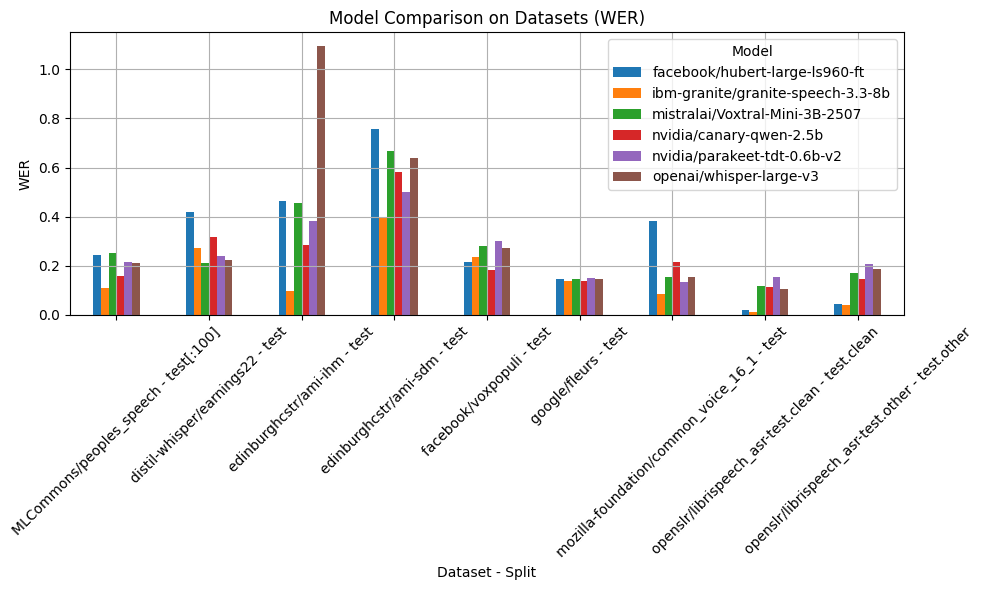

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
df = pd.read_csv("/root/workspace/experiment/asr_comparison_results.csv")

# Combine dataset and split into one column for clarity
df["dataset_split"] = df["dataset"] + " - " + df["split"]

# Choose the metric to visualize: "WER" or "CER"
metric = "WER"

# Pivot the data to get models as columns, dataset_split as index
pivot_df = df.pivot(index="dataset_split", columns="model", values=metric)

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))
plt.title(f"Model Comparison on Datasets ({metric})")
plt.ylabel(metric)
plt.xlabel("Dataset - Split")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()


,dataset,split,model,WER
0,MLCommons/peoples_speech,test[:100],ibm-granite/granite-speech-3.3-8b,0.108185
1,distil-whisper/earnings22,test,mistralai/Voxtral-Mini-3B-2507,0.210730
2,edinburghcstr/ami-ihm,test,ibm-granite/granite-speech-3.3-8b,0.097426
3,edinburghcstr/ami-sdm,test,ibm-granite/granite-speech-3.3-8b,0.393053
4,facebook/voxpopuli,test,nvidia/canary-qwen-2.5b,0.181997
5,google/fleurs,test,nvidia/canary-qwen-2.5b,0.138142
6,mozilla-foundation/common_voice_16_1,test,ibm-granite/granite-speech-3.3-8b,0.084916
7,openslr/librispeech_asr-test.clean,test.clean,ibm-granite/granite-speech-3.3-8b,0.013369
8,openslr/librispeech_asr-test.other,test.other,ibm-granite/granite-speech-3.3-8b,0.038755


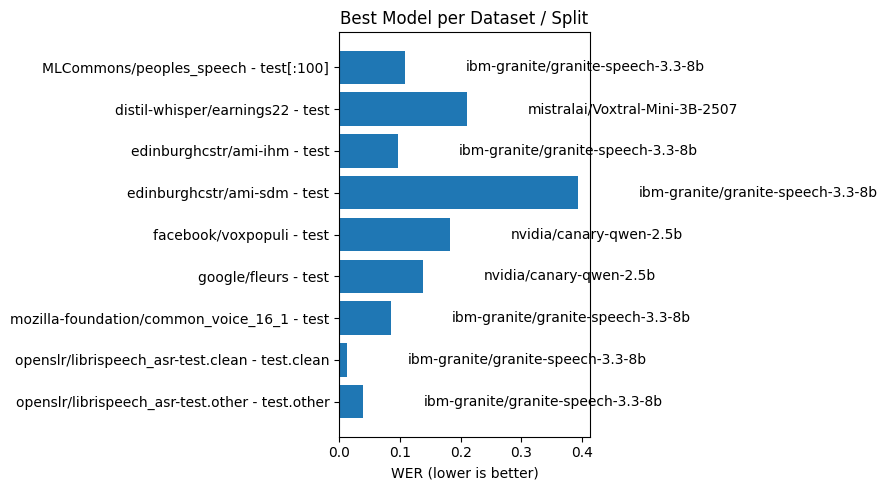

In [21]:
# -------------------------------------------
# 1. Find the best model for each dataset‑split
# -------------------------------------------
best_df = (
    df.loc[df.groupby(["dataset", "split"])["WER"].idxmin()]  # rows with the min WER
      .sort_values(["dataset", "split"])                      # nice ordering
      .reset_index(drop=True)
)

# Display the winners
display(best_df[["dataset", "split", "model", "WER"]])

# Optional: save to CSV for later
best_df.to_csv("/root/workspace/experiment/best_models_per_dataset.csv", index=False)

# -------------------------------------------
# 2. Quick plot to make winners obvious
# -------------------------------------------
plt.figure(figsize=(10, 5))
plt.barh(
    y=best_df["dataset"] + " - " + best_df["split"],
    width=best_df["WER"],
)
plt.gca().invert_yaxis()                       # best at the top
plt.xlabel("WER (lower is better)")
plt.title("Best Model per Dataset / Split")
for i, (wer, model) in enumerate(zip(best_df["WER"], best_df["model"])):
    plt.text(wer + 0.1, i, model, va="center") # write model name next to bar
plt.tight_layout()
plt.show()


In [23]:
# -----------------------------------------------
# 1. Build a pivot: rows = dataset, cols = model
# -----------------------------------------------
metric = "WER"                # change to "CER" if needed

wer_by_dataset = (
    df.groupby(["dataset", "model"])[metric]   # group by dataset & model
      .mean()                                  # average across splits → one number
      .unstack()                               # models become columns
      .sort_index()                            # tidy alphabetical order
)

# -----------------------------------------------
# 2. Save or inspect
# -----------------------------------------------
display(wer_by_dataset)
wer_by_dataset.to_csv("wer_by_dataset.csv")  # save to CSV if needed0

# -----------------------------------------------
# 3. Retrieve a single dataset’s row
# -----------------------------------------------
# dataset_name = "distil-whisper/earnings22"
# if dataset_name in wer_by_dataset.index:
#     print(f"\nWERs for {dataset_name}:")
#     print(wer_by_dataset.loc[dataset_name].to_string())
# else:
#     print(f"{dataset_name} not found. Available: {wer_by_dataset.index.tolist()}")


model,facebook/hubert-large-ls960-ft,ibm-granite/granite-speech-3.3-8b,mistralai/Voxtral-Mini-3B-2507,nvidia/canary-qwen-2.5b,nvidia/parakeet-tdt-0.6b-v2,openai/whisper-large-v3
dataset,,,,,,
MLCommons/peoples_speech,0.243847,0.108185,0.251288,0.156840,0.215226,0.212936
distil-whisper/earnings22,0.419522,0.271493,0.210730,0.315449,0.240465,0.224952
edinburghcstr/ami-ihm,0.465074,0.097426,0.455882,0.286765,0.380515,1.095588
edinburghcstr/ami-sdm,0.758684,0.393053,0.669104,0.581353,0.499086,0.639854
facebook/voxpopuli,0.214230,0.236635,0.279874,0.181997,0.301494,0.271619
google/fleurs,0.145686,0.140028,0.147100,0.138142,0.148986,0.147572
mozilla-foundation/common_voice_16_1,0.382123,0.084916,0.153073,0.216760,0.132961,0.155307
openslr/librispeech_asr-test.clean,0.019251,0.013369,0.119786,0.112299,0.152941,0.104813
openslr/librispeech_asr-test.other,0.043202,0.038755,0.170902,0.145489,0.207116,0.186150
